# ALS Patients Clustering

Amyotrophic Lateral Sclerosis (ALS) is a progressive neurodegenerative disease that affects nerve cells in the brain and spinal cord, leading to the gradual loss of muscle control and difficulties with speaking, swallowing, and breathing. It primarily targets motor neurons, which are responsible for controlling voluntary muscle movements.

In this project, I applied the K-Means clustering algorithm to classify patients, based on multiple clinical and physiological features. The goal is to identify patterns in patient data that may support early detection, better treatment and improve understanding of the disease.

## Importing libraries

In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


## Loading 

In [77]:
# set the option of displaying all the columns
pd.set_option('display.max_columns', None)

# load data
df = pd.read_csv(r"C:\Users\sanas\Desktop\Public health projects\Datasets\als_data.csv")

# display few rows of data
df.head()

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,Chloride_median,Chloride_min,Chloride_range,Creatinine_max,Creatinine_median,Creatinine_min,Creatinine_range,Gender_mean,Glucose_max,Glucose_median,Glucose_min,Glucose_range,hands_max,hands_median,hands_min,hands_range,Hematocrit_max,Hematocrit_median,Hematocrit_min,Hematocrit_range,Hemoglobin_max,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,1,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,0.021164,24.0,22.0,18.0,0.020906,31,27.5,23.0,0.027875,30.0,28.0,25.0,0.017422,8.0322,7.11945,6.5718,0.005089,90,83.0,69,0.055556,160,139.0,129,0.082011,2.49500,2.220550,2.22055,0.000956,109.0,108.0,103.0,0.020906,79.56,79.56,70.72,0.030801,1,7.4370,4.4955,4.2180,0.011216,8,7.5,6,0.005291,44.6,43.15,40.7,0.013589,156.0,146.0,143.0,0.045296,8,6.5,4,0.010582,5,3.5,0,0.013228,-1023,1,172,169.0,152.0,4.5,4.25,4.0,0.001742,79,68.0,61,0.047619,4,3.0,3,0.002646,148.0,145.5,143.0,0.017422,533,8,7.0,7,0.002646,6.0,6.0,6.0
1,2,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,0.028725,25.0,13.0,8.0,0.029617,31,17.0,14.0,0.029617,32.0,28.0,25.0,0.012195,8.3973,4.74630,4.0161,0.007633,80,78.0,64,0.028725,140,132.5,104,0.064632,2.32035,2.170650,2.02095,0.000522,108.0,102.0,100.0,0.013937,61.88,53.04,44.20,0.030801,1,6.7710,4.9950,4.0515,0.004738,8,6.0,6,0.003591,41.9,39.60,37.7,0.007317,138.0,132.0,128.0,0.017422,8,7.5,3,0.008977,9,8.0,4,0.008977,-341,1,286,264.0,230.0,5.0,4.30,3.9,0.001916,90,76.0,64,0.046679,4,4.0,3,0.001795,142.0,138.0,136.0,0.010453,649,8,7.0,5,0.005386,7.0,5.0,5.0
2,3,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,0.025000,25.0,20.0,14.0,0.019643,24,19.0,18.0,0.010714,35.0,29.0,24.0,0.019643,5.4765,4.38120,3.6510,0.003260,86,76.0,58,0.050000,120,110.0,90,0.053571,2.47005,2.295400,2.19560,0.000490,108.0,106.0,104.0,0.007143,88.40,79.56,70.72,0.031571,2,5.6610,5.1060,4.2180,0.002577,4,1.0,0,0.007143,49.1,46.20,44.0,0.009107,161.0,154.0,151.0,0.017857,4,3.0,2,0.003571,10,7.0,4,0.010714,-1181,1,233,213.0,167.0,4.1,4.00,3.9,0.000357,82,73.0,60,0.039286,4,4.0,4,0.000000,145.0,143.0,140.0,0.008929,1234,5,0.0,0,0.008929,6.0,5.0,5.0
3,4,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,0.014963,62.0,60.0,41.0,0.052369,46,40.0,33.0,0.032419,23.0,20.0,20.0,0.007481,8.0322,8.03220,6.5718,0.003642,90,80.0,70,0.049875,150,130.0,120,0.074813,2.47005,2.345300,2.23000,0.000474,109.0,107.0,106.0,0.007481,70.72,61.88,53.04,0.044090,2,5.1060,4.7730,4.6620,0.001107,6,5.5,4,0.004988,46.3,43.00,41.7,0.011471,154.0,145.0,144.0,0.024938,4,3.5,2,0.004988,12,12.0,12,0.000000,-365,2,275,233.0,204.0,4.3,4.20,4.0,0.000748,84,72.0,68,0.039900,3,3.0,3,0.000000,143.0,139.0,138.0,0.012469,2492,5,5.0,3,0.004988,7.0,6.0,5.0
4,5,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,0.020374,38.0,26.5,22.0,0.026534,35,26.5,20.0,0.024876,32.0,28.0,23.0,0.014925,5.1114,4.19865,3.6510,0.002422,100,80.0,68,0.053068,160,130.0,104,0.092869,2.

## Understanding the Data

In [78]:
# display the shape of data
df.shape

(2223, 101)

This is probably a complex structured dataset; medium-sized and high dimentional. The features do not represent row inputs, but engineered biomedical features. Many variables are aggregated as summary statistics per patient (min, max, range, slope,...).

In [79]:
# display the columns
df.columns

Index(['ID', 'Age_mean', 'Albumin_max', 'Albumin_median', 'Albumin_min',
       'Albumin_range', 'ALSFRS_slope', 'ALSFRS_Total_max',
       'ALSFRS_Total_median', 'ALSFRS_Total_min',
       ...
       'Sodium_min', 'Sodium_range', 'SubjectID', 'trunk_max', 'trunk_median',
       'trunk_min', 'trunk_range', 'Urine.Ph_max', 'Urine.Ph_median',
       'Urine.Ph_min'],
      dtype='object', length=101)

In [80]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Columns: 101 entries, ID to Urine.Ph_min
dtypes: float64(75), int64(26)
memory usage: 1.7 MB


In [81]:
# check for duplicates
df.duplicated().sum()

0

In [82]:
# check for null values
nulls = df.isnull().sum()
nulls

ID                 0
Age_mean           0
Albumin_max        0
Albumin_median     0
Albumin_min        0
                  ..
trunk_min          0
trunk_range        0
Urine.Ph_max       0
Urine.Ph_median    0
Urine.Ph_min       0
Length: 101, dtype: int64

The dataset does not include duplicates or missing data.

In [83]:
print("Minimum Age: ", df['Age_mean'].min())
print("Maximum Age: ", df['Age_mean'].max())

Minimum Age:  18
Maximum Age:  81


In [84]:
# Age distribution of patients

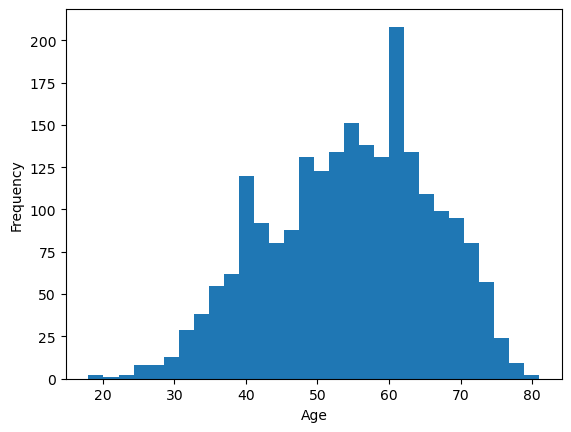

In [85]:
plt.hist(df['Age_mean'], bins=30)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

The graph highlights the distribution of average age of patients. We have a range from 20 to 80 years old. The majority of them are between 54 and 65 years old. The distribution is bell-shaped with no clear skewness or outliers. So, it is great and reasonable for ALS patients clustering.

## Data Cleansing

In [86]:
# remove data not relevant to the patient's ALS condition:

In [87]:
# drop the columns 'ID' and 'SubjectID' because they just used for identification and are not meaningful in our model creation.
df1 = df.drop(columns=['ID', 'SubjectID' ], axis=1)

In [88]:
df1.head()

,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,ALSFRS_Total_range,ALT.SGPT._max,ALT.SGPT._median,ALT.SGPT._min,ALT.SGPT._range,AST.SGOT._max,AST.SGOT._median,AST.SGOT._min,AST.SGOT._range,Bicarbonate_max,Bicarbonate_median,Bicarbonate_min,Bicarbonate_range,Blood.Urea.Nitrogen..BUN._max,Blood.Urea.Nitrogen..BUN._median,Blood.Urea.Nitrogen..BUN._min,Blood.Urea.Nitrogen..BUN._range,bp_diastolic_max,bp_diastolic_median,bp_diastolic_min,bp_diastolic_range,bp_systolic_max,bp_systolic_median,bp_systolic_min,bp_systolic_range,Calcium_max,Calcium_median,Calcium_min,Calcium_range,Chloride_max,Chloride_median,Chloride_min,Chloride_range,Creatinine_max,Creatinine_median,Creatinine_min,Creatinine_range,Gender_mean,Glucose_max,Glucose_median,Glucose_min,Glucose_range,hands_max,hands_median,hands_min,hands_range,Hematocrit_max,Hematocrit_median,Hematocrit_min,Hematocrit_range,Hemoglobin_max,Hemoglobin_median,Hemoglobin_min,Hemoglobin_range,leg_max,leg_median,leg_min,leg_range,mouth_max,mouth_median,mouth_min,mouth_range,onset_delta_mean,onset_site_mean,Platelets_max,Platelets_median,Platelets_min,Potassium_max,Potassium_median,Potassium_min,Potassium_range,pulse_max,pulse_median,pulse_min,pulse_range,respiratory_max,respiratory_median,respiratory_min,respiratory_range,Sodium_max,Sodium_median,Sodium_min,Sodium_range,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,0.021164,24.0,22.0,18.0,0.020906,31,27.5,23.0,0.027875,30.0,28.0,25.0,0.017422,8.0322,7.11945,6.5718,0.005089,90,83.0,69,0.055556,160,139.0,129,0.082011,2.49500,2.220550,2.22055,0.000956,109.0,108.0,103.0,0.020906,79.56,79.56,70.72,0.030801,1,7.4370,4.4955,4.2180,0.011216,8,7.5,6,0.005291,44.6,43.15,40.7,0.013589,156.0,146.0,143.0,0.045296,8,6.5,4,0.010582,5,3.5,0,0.013228,-1023,1,172,169.0,152.0,4.5,4.25,4.0,0.001742,79,68.0,61,0.047619,4,3.0,3,0.002646,148.0,145.5,143.0,0.017422,8,7.0,7,0.002646,6.0,6.0,6.0
1,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,0.028725,25.0,13.0,8.0,0.029617,31,17.0,14.0,0.029617,32.0,28.0,25.0,0.012195,8.3973,4.74630,4.0161,0.007633,80,78.0,64,0.028725,140,132.5,104,0.064632,2.32035,2.170650,2.02095,0.000522,108.0,102.0,100.0,0.013937,61.88,53.04,44.20,0.030801,1,6.7710,4.9950,4.0515,0.004738,8,6.0,6,0.003591,41.9,39.60,37.7,0.007317,138.0,132.0,128.0,0.017422,8,7.5,3,0.008977,9,8.0,4,0.008977,-341,1,286,264.0,230.0,5.0,4.30,3.9,0.001916,90,76.0,64,0.046679,4,4.0,3,0.001795,142.0,138.0,136.0,0.010453,8,7.0,5,0.005386,7.0,5.0,5.0
2,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,0.025000,25.0,20.0,14.0,0.019643,24,19.0,18.0,0.010714,35.0,29.0,24.0,0.019643,5.4765,4.38120,3.6510,0.003260,86,76.0,58,0.050000,120,110.0,90,0.053571,2.47005,2.295400,2.19560,0.000490,108.0,106.0,104.0,0.007143,88.40,79.56,70.72,0.031571,2,5.6610,5.1060,4.2180,0.002577,4,1.0,0,0.007143,49.1,46.20,44.0,0.009107,161.0,154.0,151.0,0.017857,4,3.0,2,0.003571,10,7.0,4,0.010714,-1181,1,233,213.0,167.0,4.1,4.00,3.9,0.000357,82,73.0,60,0.039286,4,4.0,4,0.000000,145.0,143.0,140.0,0.008929,5,0.0,0,0.008929,6.0,5.0,5.0
3,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,0.014963,62.0,60.0,41.0,0.052369,46,40.0,33.0,0.032419,23.0,20.0,20.0,0.007481,8.0322,8.03220,6.5718,0.003642,90,80.0,70,0.049875,150,130.0,120,0.074813,2.47005,2.345300,2.23000,0.000474,109.0,107.0,106.0,0.007481,70.72,61.88,53.04,0.044090,2,5.1060,4.7730,4.6620,0.001107,6,5.5,4,0.004988,46.3,43.00,41.7,0.011471,154.0,145.0,144.0,0.024938,4,3.5,2,0.004988,12,12.0,12,0.000000,-365,2,275,233.0,204.0,4.3,4.20,4.0,0.000748,84,72.0,68,0.039900,3,3.0,3,0.000000,143.0,139.0,138.0,0.012469,5,5.0,3,0.004988,7.0,6.0,5.0
4,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,0.020374,38.0,26.5,22.0,0.026534,35,26.5,20.0,0.024876,32.0,28.0,23.0,0.014925,5.1114,4.19865,3.6510,0.002422,100,80.0,68,0.053068,160,130.0,104,0.092869,2.42015,2.257975,2.17065,0.000414,107.0,104

## Data Preprocessing and Modeling

### Apply a standard scalar to the data.

In [89]:
# inintialize the standard scaler
scaler = StandardScaler()

# apply the scaler to the whole dataframe, regarding that all the features are numeric.
scaled_array = scaler.fit_transform(df1)

# convert the scaled array back to a dataframe
scaled_df = pd.DataFrame(scaled_array, columns = df1.columns, index= df1.index)

# print few rows of the scaled df:
print(scaled_df.head())

   Age_mean  Albumin_max  Albumin_median  Albumin_min  Albumin_range  \
0  0.917137     3.089417       -1.300781    -0.866550       5.480929   
1 -0.574879    -0.622016       -1.112401    -0.553303      -0.347725   
2 -1.452535     0.924415        1.148162     1.326179      -0.507103   
3  0.741606    -0.003443        0.017880     0.073191      -0.174361   
4  0.741606    -0.003443        0.583021     0.386438      -0.573670   

   ALSFRS_slope  ALSFRS_Total_max  ALSFRS_Total_median  ALSFRS_Total_min  \
0     -0.381450         -0.318520             0.134960          0.247368   
1     -0.310907          0.998995             0.888863          0.130839   
2     -0.299769         -1.447819            -1.975969         -1.150976   
3      0.208801         -0.318520             0.285741          0.480425   
4      0.456831          0.057913             0.059570          0.014311   

   ALSFRS_Total_range  ALT.SGPT._max  ALT.SGPT._median  ALT.SGPT._min  \
0           -0.301588      -0.679085 

### Apply PCA to scaled data

In [90]:
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the scaled data
pca_transformed = pca.fit_transform(scaled_df)

# Create a DataFrame for the PCA-transformed data
pca_df = pd.DataFrame(data=pca_transformed, columns=['PCA1', 'PCA2'])

# print few rows of the transformed scaled dataframe
print(pca_df.head())

       PCA1      PCA2
0 -1.426736 -2.320168
1 -1.440236 -4.872128
2  1.617859 -0.429428
3 -1.919994  2.095999
4  0.297735  0.166527


In [91]:
# Create a plot of the cluster silhouette score versus the number of clusters.

In [92]:
# define the range for the number of clusters to evaluate
cluster_range = range(2, 11)

# create an empty list to store silhouette scores
silhouette_scores = []

# perform K-means clustering for each number of clusters and calculate the silhouette score
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\sanas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\sanas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\sanas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\sanas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

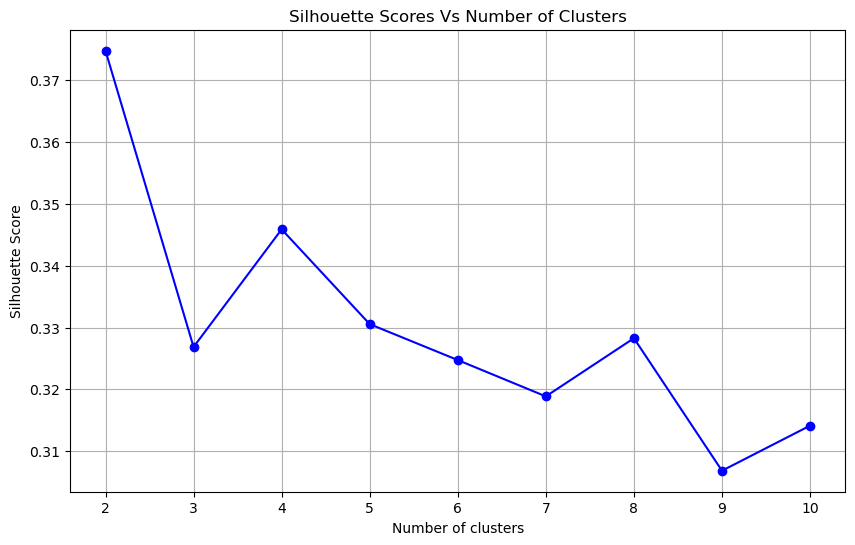

In [93]:
# plot the silhouette scores Vs the range of clusters
plt.figure(figsize=(10,6))
plt.plot(cluster_range, silhouette_scores, linestyle='-', marker='o', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores Vs Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

The optimal number of clusters is 2 because the silhouette score with 2 clusters represent the maximum, around 0.38.

In [94]:
# Fit a K-means model to the data with the optimal number of clusters chosen

In [95]:
# initialize the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)

# train the model
kmeans.fit(pca_df)

# get the clusters labels
cluster_labels = kmeans.labels_



C:\Users\sanas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [96]:
cluster_labels

array([0, 0, 1, ..., 0, 0, 1])

In [97]:
# Make a scatterplot the PCA transformed data coloring each point by its cluster value.

In [98]:
# create the column 'cluster' including the cluster labels
pca_df['cluster'] = cluster_labels

In [99]:
pca_df.head()

,PCA1,PCA2,cluster
0,-1.426736,-2.320168,0
1,-1.440236,-4.872128,0
2,1.617859,-0.429428,1
3,-1.919994,2.095999,0
4,0.297735,0.166527,1


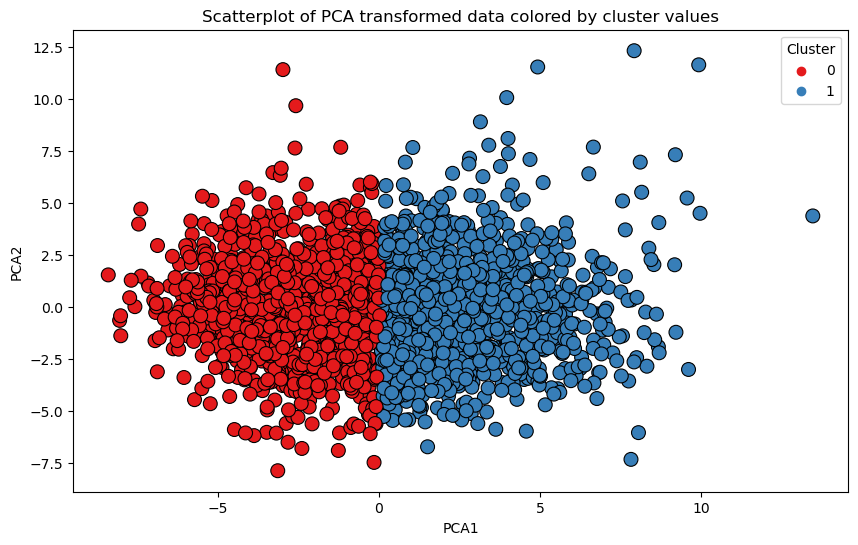

In [100]:
# create the scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(data= pca_df, x= 'PCA1', y='PCA2', palette='Set1', hue='cluster', s=100, edgecolor='k' )
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Scatterplot of PCA transformed data colored by cluster values')
plt.legend(title='Cluster')
plt.show()

- The scatter plot created highlights the structure and patterns within the data. The data is presented by the two principal components PCA1 and PCA2 which are a linear combination of the original features.

- We can see two groups suggesting that the clustering algorithm has found meaningful groupings in the data. However, if we focus on the x-axis (PCA1), we can see that the points near PCA1=0 act as a boundary between the two clusters. This boundary shows a slight overlapping indicating that the the two clusters have few similar features at this region.

- Additionally, there are points far away from the main clusters of points, they may indicate outliers. In the context of this dataset, these outliers might represent unusual cases of ALS, such as patients with rare genetic mutations, atypical symptoms, or distinct disease progressions. These rare unusual cases of ALS that could warrant further investigation.



## Translating Clusters into meaning

### 1- Cluster Summary

In [102]:
df['cluster'] = cluster_labels

cluster_summary = df.groupby('cluster').mean()

cluster_summary


### 2-Interpretation 

The most important variable in ALS progression is "ALSFRS_slope" which represents the rate of decline over time indicating how fast the disease progresses.

- ALSFRS_slope is equal to -0.43 in cluster 0 showing a slow progression while it is equal to -1.03 in cluster 1, indicating a rapid progression, more than twice.

The functional scores confirm this:
- ALSFRS_Total_median is around 31 in cluster 0 while equal to about 22 in cluster 1 highlighting a lower functional status in cluster 1.
- respiratory_min in cluster 1 is about 2.3 less than cluster 0, indicating a respiratory decline in this group.
- leg_min variable is around 1.28 for cluster 1 & 3.67 for cluster 0 highliting a massive motority decline in cluster 1.

So, we identified two distinct ALS progression phenotypes. Cluster 0 is a slowly progression ALS group and cluster 1 a highly fast progression ALS.  
The rapid progression ALS cluster shows a massive motority decline and worse respiratory function, suggesting a high risk group.




### 3-Identify The rapid progression group (Top 20 High risk patients)

In [106]:

# Rapid progression group
rapid_group = df[df['cluster'] == 1]

# Sort by ALSFRS_slope (most negative first)
rapid_extreme = rapid_group.sort_values('ALSFRS_slope')

rapid_extreme[['SubjectID','ALSFRS_slope']].head(20)


,SubjectID,ALSFRS_slope
1915,862216,-4.345238
791,357171,-4.055556
1705,770063,-3.724490
1917,862697,-3.624784
1221,549126,-3.621032
1133,505515,-3.553349
1339,605404,-3.517574
140,59268,-3.213836
293,128776,-3.101307
927,414305,-3.030013


- Those are the top 20 high risk patients (fast progressors).

### 4- Identify outliers patients

Now, we are going to measure the distance from the cluster center to find the patients who don't fit well in their clusters. These outliers are not automatically dangerous, they can represent atypical phenotypes, high progression patients or measurement errors.

In [126]:

# distance to each cluster center
distances = kmeans.transform(pca_df.drop(columns=['cluster']))

# minimum distance to assigned cluster
df['Distance_to_center'] = np.min(distances, axis=1)

# Top 1% farthest
threshold = np.percentile(df['Distance_to_center'], 95)
outliers = df[df['Distance_to_center'] > threshold]



In [127]:
outliers[['SubjectID','cluster','Distance_to_center']].sort_values("Distance_to_center", ascending=False)

,SubjectID,cluster,Distance_to_center
1293,582155,1,13.661384
2055,918151,1,13.350818
1733,777967,1,11.734650
433,189244,1,11.549277
2085,937548,0,11.433731
...,...,...,...
1478,670512,0,5.492103
958,425564,1,5.479029
1666,750195,0,5.473258
1742,785600,0,5.457365


Those are the top 5% patients distants from their cluster center. They may represent atypical/new ALS phenotypes, fast ALS progression patients, measurement errors and can lead to the discovery of new biomarkers.


So, finally I want to say that we were able today to identify the top fast-progression ALS subgroup for early proactive management, and within each cluster we flagged the most atypical 5% of patients for closer review or further investigation.